In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend available ✅")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print("MPS not available ❌, using CPU")

MPS backend available ✅
Using device: mps


In [2]:
import gc, psutil, os

def memory_report():
    total_elements = 0
    total_bytes = 0

    # Go through all live tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                total_elements += obj.numel()
                total_bytes += obj.element_size() * obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                total_elements += obj.data.numel()
                total_bytes += obj.data.element_size() * obj.data.numel()
        except Exception:
            pass

    total_mb = total_bytes / (1024 ** 2)

    process = psutil.Process(os.getpid())
    rss_mb = process.memory_info().rss / (1024 ** 2)

    print("\n--- MEMORY USAGE REPORT ---")
    print(f"Tensors Allocated: {total_elements:,}")
    print(f"Tensor Memory:     {total_mb:.2f} MB")
    print(f"Process RSS:       {rss_mb:.2f} MB")
    print("---------------------------\n")

In [3]:
# Allocate a big tensor on MPS to test
x = torch.rand((8000, 8000), device=device)  
memory_report()


--- MEMORY USAGE REPORT ---
Tensors Allocated: 64,000,000
Tensor Memory:     244.14 MB
Process RSS:       228.38 MB
---------------------------



/opt/anaconda3/envs/toki/lib/python3.10/site-packages/torch/__init__.py:1125: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/var/folders/19/6jsh26815bq0m281bn69tt9w0000gn/T/ipykernel_5003/2450541917.py:13: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif hasattr(obj, "data") and torch.is_tensor(obj.data):


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.4)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [5]:
import random
import shutil
from pathlib import Path
from tqdm import tqdm

def prepare_image_datasets(source_dir, base_dir, split_ratios=(0.7, 0.2, 0.1)):

     if not (0.999 < sum(split_ratios) < 1.001):
             raise ValueError('split_ratios must sum to 1')

     source_path = Path(source_dir)
     base_path = Path(base_dir)

     if not source_path.is_dir():
         print(f'Source directory {source_path.name} does not exist')
         return

     train_path = base_path / 'train'
     test_path = base_path / 'test'
     val_path = base_path / 'val'

     class_names = [d.name for d in source_path.iterdir() if d.is_dir()]

     if not class_names:
         print(f'Source directory {source_path.name} does not contain any class names')
         return

     for directory in [train_path, test_path, val_path]:
         for class_name in class_names:
             (directory / class_name).mkdir(parents=True, exist_ok=True)

     for class_name in class_names:

         class_source_path = source_path / class_name

         files = [f for f in class_source_path.iterdir() if f.is_file()]

         random.shuffle(files)

         total_files = len(files)
         train_end = int(total_files * split_ratios[0])
         test_end = train_end + int(total_files * split_ratios[1])

         split_data = {
             'train': (files[:train_end], train_path),
             'test': (files[train_end:test_end], test_path),
             'val': (files[test_end:], val_path)
         }

         print(f"Copying {class_name} to {base_path}")

         for split_name, (file_list, destination_path) in split_data.items():

             dest_class_path = destination_path / class_name

             for file_path in tqdm(file_list, desc=f'Copying {split_name} files'):

                 shutil.copy2(file_path, dest_class_path / file_path.name)

         print(f'Copying {class_name} finished!')

     print("Data splitting successful!")

In [6]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [7]:
source_data_dir = '/Users/jameskierdoliguez/Desktop/rice_leaf/dataset'
base_data_dir = '/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset'

if not source_data_dir or not base_data_dir:
    raise ValueError('Source and base data directory not found')

prepare_image_datasets(source_data_dir, base_data_dir, split_ratios=(0.7, 0.2, 0.1))

Copying sheath_blight to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 159/159 [00:00<00:00, 2144.76it/s]


Copying sheath_blight finished!
Copying Brownspot to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 151/151 [00:00<00:00, 3373.55it/s]


Copying Brownspot finished!
Copying Blast to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 145/145 [00:00<00:00, 3261.93it/s]


Copying Blast finished!
Copying Bacterialblight to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 160/160 [00:00<00:00, 3052.35it/s]


Copying Bacterialblight finished!
Copying Tungro to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 132/132 [00:00<00:00, 3657.82it/s]

Copying Tungro finished!
Data splitting successful!


In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class LeafDiseaseClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_filters, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [8]:
class LeafDiseaseClassifierEfficientNetV2M(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierEfficientNetV2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


In [10]:
import torch

def train_and_validate(model, optimizer, criterion, train_dataloader, validation_dataloader, num_epoch, device, scheduler, model_dir, patience=3, min_delta=0.001):

    train_losses = []
    validation_losses = []
    accuracies = []
    patience_counter = 0
    best_validation_loss=float('inf')
    best_session_accuracy = float('inf')
    stop_early=False
    fully_stop = False

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_eval_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc=f"Validate Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)
                loss = criterion(logits, labels)
                running_eval_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_eval_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        scheduler.step(validation_loss)

        current_lr = optimizer.param_groups[0]['lr']
        epoch_summary = f'Epoch {epoch+1}/{num_epoch} |lr: {current_lr}| Train Loss: {training_loss:.4f} | Evaluate Loss: {validation_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'
        
        elif device.type == 'mps':
            try:
                allocated_gb = torch.mps.current_allocated_memory() / (1024 ** 3)
                reserved_gb = torch.mps.driver_allocated_memory() / (1024 ** 3)
                epoch_summary += f' | MPS Memory (Alloc/Driver): {allocated_gb:.2f}/{reserved_gb:.2f} GB'
            except AttributeError:
                epoch_summary += " | MPS Memory: not available in this PyTorch version"

        tqdm.write(epoch_summary)

        if validation_loss < best_validation_loss - min_delta:

            patience_counter = 0
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), model_dir)
        else:
            patience_counter += 1
            tqdm.write(f'No improvement for {patience_counter}/{patience} epochs')

        if  validation_loss >= training_loss:
            tqdm.write(f'Training stopped! Validation loss: {validation_loss:.4f} | Training loss: {training_loss:.4f}')
            fully_stop = True
            break

        if patience_counter >= patience:
            tqdm.write(f'Early stopping triggered after {patience_counter} epochs')
            stop_early = True
            break

    tqdm.write('Session complete')

    return {'train_loss': train_losses, 'validation_loss': validation_losses, 'accuracy': accuracies}, best_session_accuracy, stop_early, fully_stop

<h2>  Saving and plott</h2>

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_training_result(*results):

    full_training_loss = []
    full_validation_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_validation_loss.extend(result.get('validation_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Validation Loss': full_validation_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_results(file_name):

    data = pd.read_csv(file_name)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle('Training and Validation Loss Comparison', fontsize=16)

    historical_losses = df.melt(id_vars=['epoch'],value_vars=['train_loss', 'validation_loss'], var_name='Loss Type', value_name='Loss')

    sns.lineplot(data=historical_losses, hue='Loss Type', markers='o' ,x='epoch' , y='Loss', ax=axes[0])

    axes[0].set_title('Training and Validation Loss Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    sns.lineplot(data=df, x='epoch', y='accuracy', color='g', markers='o', ax=axes[1])
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))

    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(history, filename):

    training_loss = history.get('train_loss', [])
    test_loss = history.get('validation_loss', [])
    accuracy = history.get('accuracy', [])

    data_dict = pd.DataFrame({
        'train_loss': training_loss,
        'validation_loss': test_loss,
        'accuracy': accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")
        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'validation_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")



In [12]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/test', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/val', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [13]:
from torch.optim import lr_scheduler

def incremental_training(model, sessions, criterion, train_dataloader, validation_dataloader, device, model_dir):

    # --- New code to display image counts ---
    num_train_images = len(train_dataloader.dataset) 
    num_val_images = len(validation_dataloader.dataset) 
    print(f"--- Starting Incremental Training ---") 
    print(f"Training images: {num_train_images}")
    print(f"Validation images: {num_val_images}") # <-- new
    
    full_history = []
    accuracies = []  # <-- new: collect accuracies
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=lr, weight_decay=1e-2
        )
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.5, mode='min', patience=2, min_lr=1e-7
        )

        session_history, session_best_accuracy, stop_early, full_stop = train_and_validate(
            model, optimizer, criterion, train_dataloader, validation_dataloader,
            epochs, device, scheduler, model_dir
        )

        full_history.append(session_history)
        accuracies.append(session_best_accuracy)  # <-- track best accuracy per session
        save_historical_data(session_history)

        if session_best_accuracy > best_overall_accuracy:
            best_overall_accuracy = session_best_accuracy

        if full_stop:
            print("Full stop triggered! Possible overfitting in further sessions.")
            break

        if stop_early:
            print("Early stopping triggered. Moving to next session or finishing training.")

    print(f"\n--- Incremental training finished. Best overall accuracy: {best_overall_accuracy:.2f}% ---")
    return full_history, accuracies  # <-- return both


In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5
learning_rate = 1e-3
weight_decay = 1e-2
criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierMobileNetV2(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/MobileNetV2/MobileNetV2-m_rice_leaf_disease_classificationV1.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/MobileNetV2/MobileNetV2-m_rice_pest_classificationV1.csv'

training_sessions = [

    {'epochs': 10, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 20, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 30, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 40, 'lr': 1e-5, 'unfreeze_layer': 3},

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir)

plot_training_result(*result)
plot_accuracy(*result)

--- Starting Incremental Training ---
Training images: 5183
Validation images: 1480

--- Starting Training Session 1/4 ---


Validate Epoch 1: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.41it/s]


Epoch 1/10 |lr: 0.0005| Train Loss: 1.3302 | Evaluate Loss: 0.9860 | Accuracy: 76.55% | MPS Memory (Alloc/Driver): 0.30/3.33 GB


Validate Epoch 2: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.84it/s]


Epoch 2/10 |lr: 0.0005| Train Loss: 0.9652 | Evaluate Loss: 0.7074 | Accuracy: 81.35% | MPS Memory (Alloc/Driver): 0.29/5.25 GB


Validate Epoch 3: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.86it/s]


Epoch 3/10 |lr: 0.0005| Train Loss: 0.8096 | Evaluate Loss: 0.5843 | Accuracy: 83.31% | MPS Memory (Alloc/Driver): 0.29/4.86 GB


Validate Epoch 4: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.82it/s]


Epoch 4/10 |lr: 0.0005| Train Loss: 0.7045 | Evaluate Loss: 0.5158 | Accuracy: 85.74% | MPS Memory (Alloc/Driver): 0.29/4.86 GB


Validate Epoch 5: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.80it/s]


Epoch 5/10 |lr: 0.0005| Train Loss: 0.6571 | Evaluate Loss: 0.4549 | Accuracy: 87.09% | MPS Memory (Alloc/Driver): 0.29/4.86 GB


Validate Epoch 6: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.82it/s]


Epoch 6/10 |lr: 0.0005| Train Loss: 0.6063 | Evaluate Loss: 0.4282 | Accuracy: 87.36% | MPS Memory (Alloc/Driver): 0.29/4.86 GB


Validate Epoch 7: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.72it/s]


Epoch 7/10 |lr: 0.0005| Train Loss: 0.5768 | Evaluate Loss: 0.3777 | Accuracy: 88.58% | MPS Memory (Alloc/Driver): 0.29/4.48 GB


Validate Epoch 8: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.76it/s]


Epoch 8/10 |lr: 0.0005| Train Loss: 0.5597 | Evaluate Loss: 0.3603 | Accuracy: 89.19% | MPS Memory (Alloc/Driver): 0.29/4.48 GB


Validate Epoch 9: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.78it/s]


Epoch 9/10 |lr: 0.0005| Train Loss: 0.5254 | Evaluate Loss: 0.3455 | Accuracy: 89.19% | MPS Memory (Alloc/Driver): 0.29/4.48 GB


Validate Epoch 10: 100%|████████████████████████| 24/24 [00:05<00:00,  4.77it/s]


Epoch 10/10 |lr: 0.0005| Train Loss: 0.5143 | Evaluate Loss: 0.3376 | Accuracy: 89.59% | MPS Memory (Alloc/Driver): 0.29/4.48 GB
Session complete
Creating new historical data...
Historical data saved successfully!

--- Starting Training Session 2/4 ---

Unfreezing feature layer at index: -1


Validate Epoch 1: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.76it/s]


Epoch 1/20 |lr: 0.0001| Train Loss: 0.4767 | Evaluate Loss: 0.2938 | Accuracy: 91.15% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 2: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.78it/s]


Epoch 2/20 |lr: 0.0001| Train Loss: 0.4524 | Evaluate Loss: 0.2603 | Accuracy: 91.55% | MPS Memory (Alloc/Driver): 0.30/5.25 GB


Validate Epoch 3: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.82it/s]


Epoch 3/20 |lr: 0.0001| Train Loss: 0.4088 | Evaluate Loss: 0.2548 | Accuracy: 92.50% | MPS Memory (Alloc/Driver): 0.30/4.86 GB


Validate Epoch 4: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.78it/s]


Epoch 4/20 |lr: 0.0001| Train Loss: 0.3885 | Evaluate Loss: 0.2161 | Accuracy: 93.24% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 5: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.73it/s]


Epoch 5/20 |lr: 0.0001| Train Loss: 0.3585 | Evaluate Loss: 0.2080 | Accuracy: 94.05% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 6: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.79it/s]


Epoch 6/20 |lr: 0.0001| Train Loss: 0.3423 | Evaluate Loss: 0.1788 | Accuracy: 94.59% | MPS Memory (Alloc/Driver): 0.30/5.25 GB


Validate Epoch 7: 100%|█████████████████████████| 24/24 [00:04<00:00,  4.82it/s]


Epoch 7/20 |lr: 0.0001| Train Loss: 0.3340 | Evaluate Loss: 0.1831 | Accuracy: 94.39% | MPS Memory (Alloc/Driver): 0.30/5.25 GB
No improvement for 1/3 epochs


Validate Epoch 8: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.61it/s]


Epoch 8/20 |lr: 0.0001| Train Loss: 0.3281 | Evaluate Loss: 0.1653 | Accuracy: 95.07% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 9: 100%|█████████████████████████| 24/24 [00:05<00:00,  4.66it/s]


Epoch 9/20 |lr: 0.0001| Train Loss: 0.3082 | Evaluate Loss: 0.1504 | Accuracy: 95.27% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 10: 100%|████████████████████████| 24/24 [00:05<00:00,  4.72it/s]


Epoch 10/20 |lr: 0.0001| Train Loss: 0.2983 | Evaluate Loss: 0.1392 | Accuracy: 95.81% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 11: 100%|████████████████████████| 24/24 [00:05<00:00,  4.79it/s]


Epoch 11/20 |lr: 0.0001| Train Loss: 0.2823 | Evaluate Loss: 0.1329 | Accuracy: 96.35% | MPS Memory (Alloc/Driver): 0.30/5.25 GB


Validate Epoch 12: 100%|████████████████████████| 24/24 [00:05<00:00,  4.74it/s]


Epoch 12/20 |lr: 0.0001| Train Loss: 0.2704 | Evaluate Loss: 0.1357 | Accuracy: 96.15% | MPS Memory (Alloc/Driver): 0.30/4.48 GB
No improvement for 1/3 epochs


Validate Epoch 13: 100%|████████████████████████| 24/24 [00:05<00:00,  4.78it/s]


Epoch 13/20 |lr: 0.0001| Train Loss: 0.2793 | Evaluate Loss: 0.1256 | Accuracy: 96.15% | MPS Memory (Alloc/Driver): 0.30/5.25 GB


Validate Epoch 14: 100%|████████████████████████| 24/24 [00:05<00:00,  4.77it/s]


Epoch 14/20 |lr: 0.0001| Train Loss: 0.2625 | Evaluate Loss: 0.1227 | Accuracy: 96.28% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 15: 100%|████████████████████████| 24/24 [00:05<00:00,  4.76it/s]


Epoch 15/20 |lr: 0.0001| Train Loss: 0.2562 | Evaluate Loss: 0.1230 | Accuracy: 96.62% | MPS Memory (Alloc/Driver): 0.30/4.48 GB
No improvement for 1/3 epochs


Validate Epoch 16: 100%|████████████████████████| 24/24 [00:05<00:00,  4.74it/s]


Epoch 16/20 |lr: 0.0001| Train Loss: 0.2412 | Evaluate Loss: 0.1049 | Accuracy: 97.03% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 17: 100%|████████████████████████| 24/24 [00:05<00:00,  4.66it/s]


Epoch 17/20 |lr: 0.0001| Train Loss: 0.2582 | Evaluate Loss: 0.1054 | Accuracy: 97.09% | MPS Memory (Alloc/Driver): 0.30/4.48 GB
No improvement for 1/3 epochs


Validate Epoch 18: 100%|████████████████████████| 24/24 [00:05<00:00,  4.72it/s]


Epoch 18/20 |lr: 0.0001| Train Loss: 0.2400 | Evaluate Loss: 0.1035 | Accuracy: 97.36% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 19: 100%|████████████████████████| 24/24 [00:05<00:00,  4.79it/s]


Epoch 19/20 |lr: 0.0001| Train Loss: 0.2429 | Evaluate Loss: 0.0966 | Accuracy: 97.43% | MPS Memory (Alloc/Driver): 0.30/4.48 GB


Validate Epoch 20: 100%|████████████████████████| 24/24 [00:05<00:00,  4.73it/s]


Epoch 20/20 |lr: 0.0001| Train Loss: 0.2312 | Evaluate Loss: 0.0877 | Accuracy: 97.64% | MPS Memory (Alloc/Driver): 0.30/4.48 GB
Session complete
historical data exists! Appending new data.
Historical data saved successfully!

--- Starting Training Session 3/4 ---

Unfreezing feature layer at index: -2


Train epoch: 1:  93%|█████████████████████████  | 38/41 [00:21<00:01,  1.59it/s]

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5
learning_rate = 1e-3
weight_decay = 1e-2
criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierEfficientNetV2M(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/EfficientNetV2M/EfficientNetV2M-m_rice_leaf_disease_classificationV1.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/EfficientNetV2M/EfficientNetV2M-m_rice_pest_classificationV1.csv'

training_sessions = [

    {'epochs': 10, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 20, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 30, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 40, 'lr': 1e-5, 'unfreeze_layer': 3},

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir)

plot_training_result(*result)
plot_accuracy(*result)

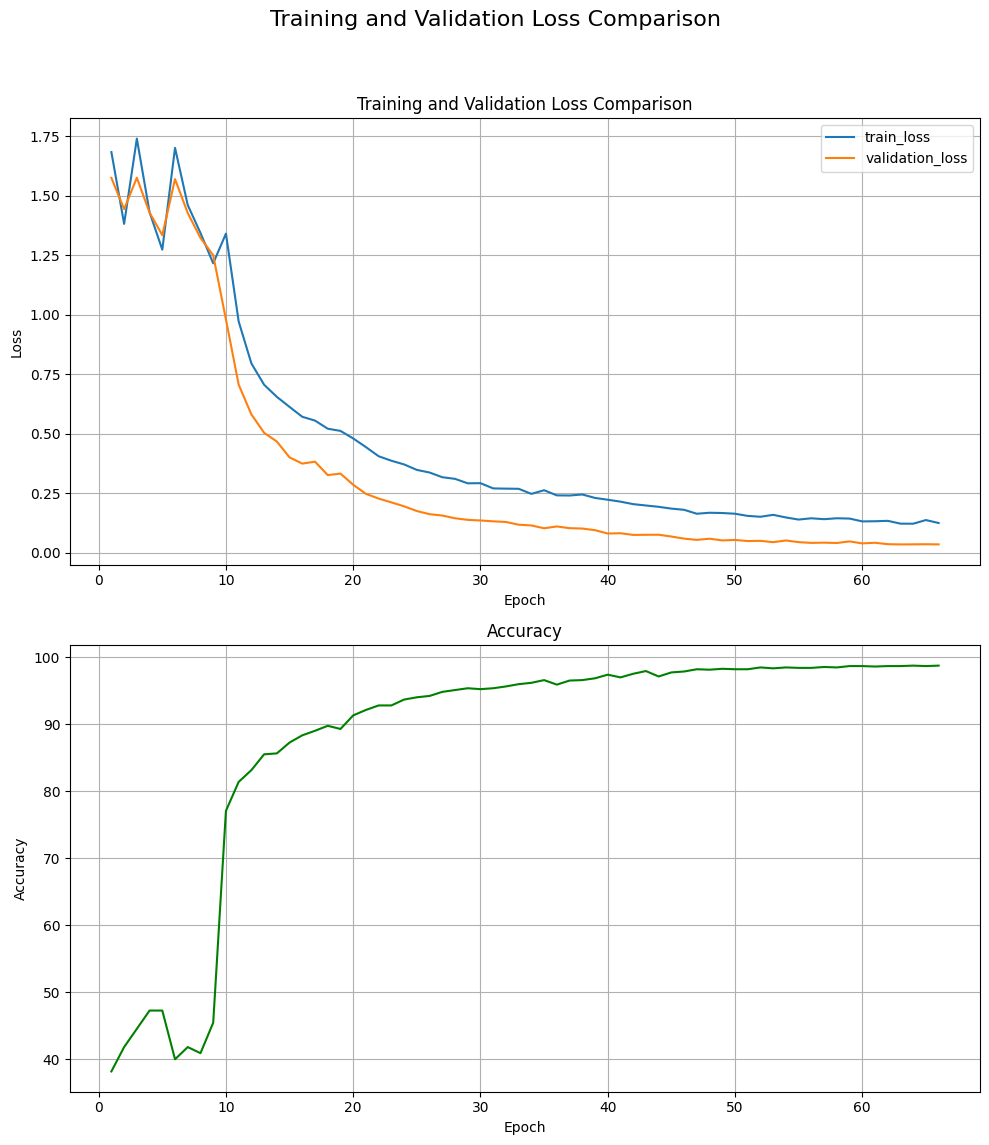

In [14]:
plot_historical_results('/Users/jameskierdoliguez/Desktop/train_results/MobileNetV2/MobileNetV2-m_rice_pest_classificationV1.csv')

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5
criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierMobileNetV2(num_classes=classes).to(hardware)
model_dir = '/Users/jameskierdoliguez/Desktop/models/MobileNetV2/MobileNetV2-m_rice_leaf_disease_classificationV1_nodecay.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/MobileNetV2/MobileNetV2-m_rice_pest_classificationV1_nodecay.csv'


training_sessions = [

    {'epochs': 15, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 35, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 45, 'lr': 1e-5, 'unfreeze_layer': 3},

    {'epochs': 55, 'lr': 5e-6, 'unfreeze_layer': 4},

    {'epochs': 65, 'lr': 1e-6, 'unfreeze_layer': 5},

    {'epochs': 75, 'lr': 5e-7, 'unfreeze_layer': 6}

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir)

plot_training_result(*result)
plot_accuracy(*result)

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5
criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierEfficientNetV2M(num_classes=classes).to(hardware)
model_dir = '/Users/jameskierdoliguez/Desktop/models/EfficientNetV2M/EfficientNetV2M-m_rice_leaf_disease_classificationV1_nodecay.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/EfficientNetV2M/EfficientNetV2M-m_rice_pest_classificationV1_nodecay.csv'


training_sessions = [

    {'epochs': 15, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 35, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 45, 'lr': 1e-5, 'unfreeze_layer': 3},

    {'epochs': 55, 'lr': 5e-6, 'unfreeze_layer': 4},

    {'epochs': 65, 'lr': 1e-6, 'unfreeze_layer': 5},

    {'epochs': 75, 'lr': 5e-7, 'unfreeze_layer': 6}

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir)

plot_training_result(*result)
plot_accuracy(*result)

In [14]:
from PIL import Image
import numpy as np
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [ ]:
import torchvision.models as models

classes_names = train_set.classes
if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
model_inference = LeafDiseaseClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    '/Users/jameskierdoliguez/Desktop/models/MobileNetV2/MobileNetV2-m_rice_leaf_disease_classificationV1_nodecay.pt', map_location=hardware))

image_path = 'datasets/val/brown-planthopper/7 (758).jpg'
unrelated = 'unrelated_data/eagle.jpg'

leaf_disease, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted leaf disease is: {leaf_disease}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")
#
# true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)

The predicted pest is: green-leafhopper
Confidence: 96.54%
Overall score: [2.8930137e-02 9.6535772e-01 2.4244012e-04 1.4524395e-03 3.8111259e-03
 2.0627611e-04]


100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Classification Report
                   precision    recall  f1-score   support

brown-planthopper       0.95      0.92      0.94       246
 green-leafhopper       0.93      0.93      0.93       215
   rice-black-bug       0.94      1.00      0.97        16
 rice-leaf-folder       0.96      0.99      0.97       275
       stem-borer       0.98      0.97      0.98       197
     whorl-maggot       0.96      0.97      0.96       125

         accuracy                           0.96      1074
        macro avg       0.95      0.96      0.96      1074
     weighted avg       0.96      0.96      0.96      1074

Accuracy: 95.53%

Confusion Matrix


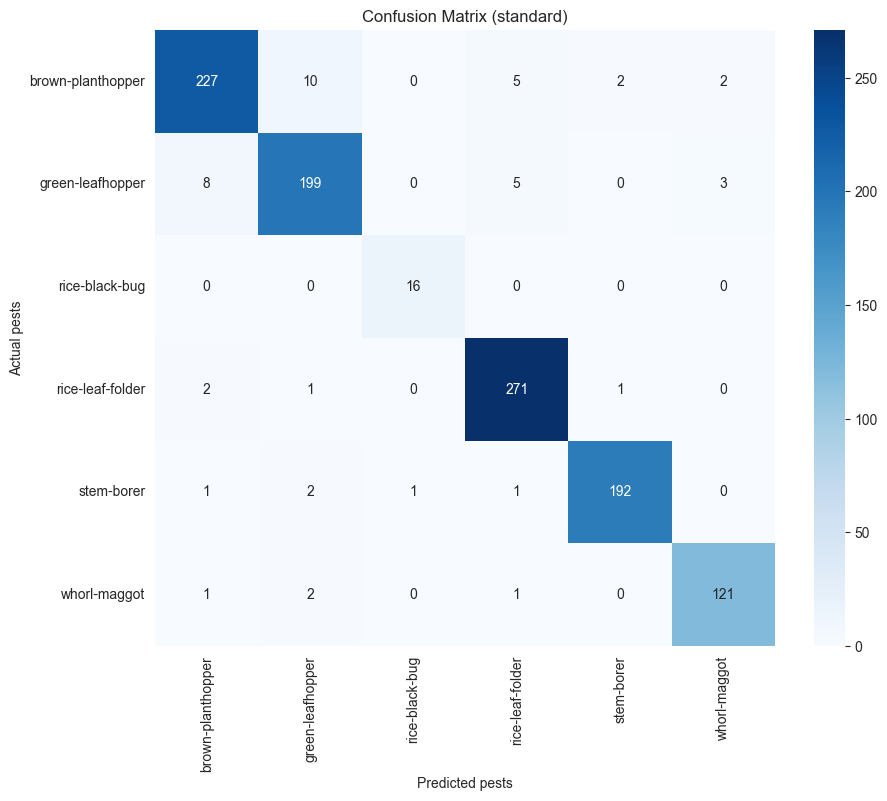

In [17]:
import torchvision.models as models

classes_names = train_set.classes
if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
model_inference = LeafDiseaseClassifierEfficientNetV2M(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    '/Users/jameskierdoliguez/Desktop/models/EfficientNetV2M/EfficientNetV2M-m_rice_leaf_disease_classificationV1_nodecay.pt', map_location=hardware))
image_path = 'datasets/val/brown-planthopper/7 (758).jpg'
unrelated = 'unrelated_data/imagesz.jpg'

leaf_disease, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=unrelated, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted leaf disease is: {leaf_disease}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)